In [ ]:
import torch as th
import numpy as np
import random

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
import torchvision.datasets

MNIST_train = torchvision.datasets.FashionMNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.FashionMNIST('./', download = True, train = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

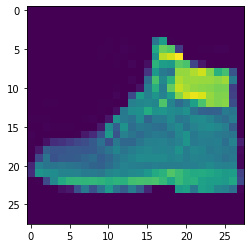

tensor(9)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[90, :, :])
plt.show()
print(y_train[90])

In [ ]:
X_train = X_train.reshape([-1, 784])
X_test = X_test.reshape([-1, 784])


In [ ]:
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = th.nn.Linear(784, 498)
    self.act1 = th.nn.ReLU()
    self.fc2 = th.nn.Linear(498,128)
    self.act2 = th.nn.ReLU()
    self.fc3 = th.nn.Linear(128,10)
    self.sm = th.nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x
  
  def predict(self,x):
    x=self.forward(x)
    x=x.to(device)
    x=self.sm(x)
    return x
net = MNISTnet()

In [ ]:
th.cuda.is_available()

True

In [ ]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)

In [ ]:
#net.parameters(), lr=0.001
loss = th.nn.CrossEntropyLoss()
opt = [th.optim.Adam, th.optim.SGD, th.optim.Adagrad, th.optim.Adadelta, th.optim.Adamax, th.optim.NAdam, th.optim.RMSprop]

In [ ]:
def Accuracy():
  preds = net.predict(X_test)
  true_vals, all_vals = 0, 0
  for i in range(10000):
    probab = list(preds.cpu().detach().numpy()[i])
    if probab.index(max(probab)) == y_test.cpu().numpy()[i]:
      true_vals += 1
    all_vals += 1
  return true_vals/all_vals

In [ ]:
import time 
import pandas as pd

batch_size = 64
X_test = X_test.to(device)
y_test = y_test.to(device)
data = []

X_train = X_train.to(device)
y_train = y_train.to(device)
for func in opt:
  start = time.time()
  net = MNISTnet()
  net = net.to(device)
  opt1 = func(net.parameters(), lr=0.001)
  for epoch in range(50):
    order = np.random.permutation(len(X_train))
    for start_index in range (0, len(X_train), batch_size):
      opt1.zero_grad() 
      batch_index = order[start_index:start_index+batch_size]
      X_batch = X_train[batch_index]
      y_batch = y_train[batch_index]
      preds = net.forward(X_batch)
      # preds = preds.to(th.float32)
      # y_batch = y_batch.to(th.float32)
      loss_val = loss(preds, y_batch)
      loss_val.backward()

      opt1.step()
  end = time.time() 
  sl = {'Function': str(func), 'time': (end-start)*10**3, 'score': Accuracy()}
  data.append(sl) 

df = pd.DataFrame(data) 
df

tensor([[ -16.7499,  -31.7838,   -7.3452,  ...,   21.4494,   -2.4059,
           30.1236],
        [   0.8040,  -44.1188,   26.5228,  ..., -373.8058,   -3.2088,
         -222.4827],
        [ -67.1414,   59.1418, -100.3444,  ..., -533.2073, -165.3394,
         -472.9292],
        ...,
        [ -19.3371,   39.2292,    6.9654,  ...,  -98.2603,   96.3344,
         -210.5145],
        [ -79.0439,   63.0756, -104.9831,  ..., -496.6885, -160.2220,
         -469.3727],
        [ -39.6427,  -78.7235,  -46.3581,  ...,    7.9301,  -15.3218,
            5.2617]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ -0.7446,  -8.3855,  -7.0711,  ...,  11.3014,   0.4589,  23.1644],
        [ 14.2528,   0.4347,  22.5176,  ...,  -7.6637,  -8.7056,  -5.7196],
        [ 15.6569,  33.7321,   4.5610,  ...,  -5.1220,  -7.6579, -10.1792],
        ...,
        [ 10.4704, -19.3963,   0.3973,  ...,  -8.9411,  21.7010, -13.5786],
        [  8.8996,  34.0818,  -2.6416,  ...,  -2.4121,  -5.1236,  -4.3673],
    

,Function,time,score
0,<class 'torch.optim.adam.Adam'>,97555.912733,0.8842
1,<class 'torch.optim.sgd.SGD'>,61478.218555,0.8808
2,<class 'torch.optim.adagrad.Adagrad'>,75067.101240,0.8835
3,<class 'torch.optim.adadelta.Adadelta'>,84877.767801,0.8608
4,<class 'torch.optim.adamax.Adamax'>,91947.050571,0.8924
5,<class 'torch.optim.nadam.NAdam'>,92650.851965,0.8790
6,<class 'torch.optim.rmsprop.RMSprop'>,72107.219458,0.8649


In [ ]:
def pred_test(i): 
  img = X_test[i].view(1, 784) 
  with th.no_grad():
    logps = net.predict(img)
  probab = list(logps.cpu().numpy()[0])
  print("Predicted class =", probab.index(max(probab)))
  print("Current class =", y_test.cpu().numpy()[i])
  plt.subplots(figsize=(6,9))
  plt.imshow(X_test.cpu()[i].resize(1, 28, 28).numpy().squeeze())
  plt.show()

tensor([[-4.6391e+01, -3.9048e+02, -5.3683e+01, -1.0047e+02, -6.1164e+01,
          1.1607e-01, -4.1021e+01,  7.1251e+00, -4.2854e+01,  3.0410e+00]],
       device='cuda:0')
Predicted class = 7
Current class = 7


/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


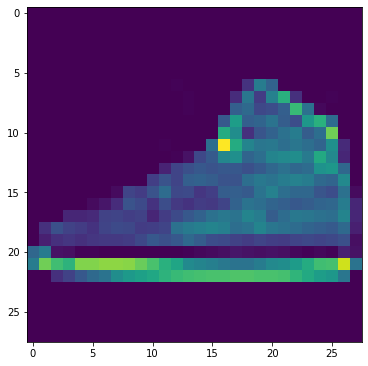

In [ ]:
pred_test(45)